## 数据准备

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

data_1 = np.random.randn(200, 2)+[1, 1]
data_2 = np.random.randn(200, 2)+[4, 4]
data_3 = np.random.randn(200, 2)+[7, 1]

data = np.concatenate((data_1, data_2, data_3), axis=0)


X_train, X_test = train_test_split(data, test_size=0.2)

## 模型基本
有了数据之后，最先做的应该就是选取$k$个质心点，为了满足选取的质心点在数据各维度的范围内，先计算数据各维度上的均值与方差，再引入随机值做质心选取。

In [13]:
# def gen_center(X_train, k):
#     n_sample = X_train.shape[0]
#     n_feature = X_train.shape[1]

#     # 为了在数据范围内产生随机质心，首先计算各特征的统计量
#     f_mean = np.mean(X_train, axis=0).reshape((1, n_feature))
#     f_std = np.std(X_train, axis=0).reshape((1, n_feature))

#     centers = np.random.randn(k, n_feature)*f_std+f_mean    # (k,n_feature)
#     return centers


# k=3
# centers = gen_center(X_train, k)

选取好质心后，接下来开始迭代。
- 计算每个样本离每个质心的距离，该距离用矩阵保存，维度为$(n\_sample,k)$，然后使用```np.argmin()```就能很方便求出样本点被归到哪个类别

In [14]:
# n_sample = X_train.shape[0]

# clusters = np.zeros(n_sample)    # 每个样本都对应一个类，相当于Y
# dist = np.zeros((n_sample, k))    # 每个样本对每个质心都有一个距离

# for i in range(k):
#     dist[:, i] = np.linalg.norm(X_train-centers[i], axis=1)

# # 样本对应的类别为距离最近的质心
# clusters = np.argmin(dist, axis=1)

- 根据分类好的数据，计算每个类别下的质心，并更新质心

In [ ]:
# # 计算每个类别下的均值坐标，更新质心
# for i in range(k):
#     centers[i] = np.mean(X_train[clusters == i], axis=0)

KMeans结束迭代的条件有两个：一是设置最大迭代次数，二是当质心不再移动时。为了能够计算每次迭代质心的移动距离，使用两个变量```cent_pre```与```cent_cur```来保存当前迭代的质心与上轮质心。

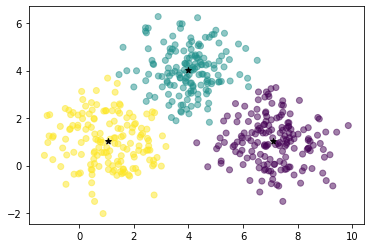

In [16]:
clusters = np.zeros(n_sample)    # 每个样本都对应一个类，相当于Y
dist = np.zeros((n_sample, k))    # 每个样本对每个质心都有一个距离

from copy import deepcopy
cent_pre = np.zeros(centers.shape)
cent_cur = gen_center(X_train,k)
cent_move = np.linalg.norm(cent_cur-cent_pre)    # 每轮迭代后质心的移动距离

epsilon = 1e-3    # 质心需要移动的最小距离
epoch = 0    # 当前迭代次数
max_iter = 50    # 最大迭代次数
while epoch < max_iter and cent_move > epsilon:
    epoch += 1

    # 首先计算每个样本离每个质心的距离
    for i in range(k):
        dist[:, i] = np.linalg.norm(X_train-cent_cur[i], axis=1)

    # 样本对应的类别为距离最近的质心
    clusters = np.argmin(dist, axis=1)

    cent_pre = deepcopy(cent_cur)

    # 计算每个类别下的均值坐标，更新质心
    for i in range(k):
        cent_cur[i] = np.mean(X_train[clusters == i], axis=0)

    cent_move = np.linalg.norm(cent_cur-cent_pre)
    
plt.clf()
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, c=clusters)
plt.scatter(cent_cur[:, 0], cent_cur[:, 1], marker='*', c='k')
plt.show()

模型训练好之后，对测试样本进行预测归类，并做可视化。

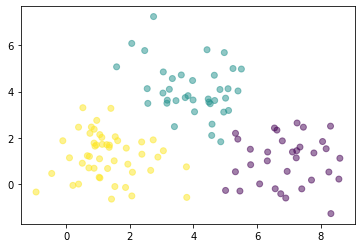

In [17]:
test_sample = X_test.shape[0]
dist_test = np.zeros((test_sample, k))

# KMeans预测的实质不过是计算各测试样例到各质心的距离，选取最近的质心作为归类
for i in range(k):
    dist_test[:, i] = np.linalg.norm(X_test-cent_cur[i], axis=1)
clus_pred = np.argmin(dist_test, axis=1)

plt.clf()
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.5, c=clus_pred)
plt.show()

## 改进
KMeans最大的缺陷就在于不合适的初始质心会陷入局部解而无法跳出，解决办法也有两个：一是多次运行KMeans算法，将最后的聚类结果做投票；二是改进质心的选取方法，如KMeans++。

KMeans++的思想很朴素，简单地认为初始各质心应该相互离得比较远，在KMeans++中，质心是逐个被选取的，随机点被选取为质心的概率跟已有质心的距离成正比，即离已有质心越远的点越有可能被选取为质心。易得对于参数为$k$的KMeans++模型，在选取质心的阶段就需要计算$k-1$次距离矩阵。

### 多次重复的KMeans

In [ ]:
# 待补充

### KMeans++
关键在于初始质心的选取，需要计算：
$$
D(x^{(i)})=min[dist(x^{(i)},C_{1}),dist(x^{(i)},C_{2}),...,dist(x^{(i)},C_{K})]
$$
该点$x^{(i)}$被选为质心的概率为：
$$
P(x^{(i)})=\frac{D(x^{(i)})^{2}}{{\sum}D(x^{(j)})^{2}}
$$

In [ ]:
def gen_center(X_train, k):
    n_sample, n_feature = X_train.shape

    # 第一个质心随机选
    idx = np.random.randint(0, n_sample)
    centers = [X_train[idx, :]]

    # 选出后面k-1个质心
    for i in range(1, k):
        dist = np.zeros((n_sample, len(centers)))    # 各样本到质心的距离矩阵
        for cent_idx in range(len(centers)):
            dist[:, cent_idx] = np.linalg.norm(X_train-centers[cent_idx],
                                               axis=1)

        dist = np.min(dist, axis=1)    # 所有样本离各质心距离的最小值
        p = dist/np.sum(dist)    # 归一化后的最小距离当做概率进行下一个质心的选取，这里没有计算平方

        next_cent_idx = np.random.choice(n_sample, p=p)
        centers.append(X_train[next_cent_idx])

    return np.array(centers)


centers = gen_center(X_train, 3)
plt.clf()
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], marker='*', c='k')
plt.show()